# House pricing

Objective: 
> 1. 資料清洗與轉換  
> 2. 探索式資料分析 (EDA)  
> 3. 特徵工程 (feautre engineering)  
> 4. 建立模型  
> 5. 調整參數  
> 6. 上傳結果  



In [3]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from scipy import stats
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

## Dataset Exploration
讀取資料，對資料觀察了解特性

In [12]:
df_train = pd.DataFrame(pd.read_csv('train.csv'), columns = pd.read_csv('train.csv',index_col=False).columns)
df_val = df_train['SalePrice']
df_test = pd.DataFrame(pd.read_csv('test.csv'), columns = pd.read_csv('test.csv',index_col=False).columns)
target = pd.DataFrame(pd.read_csv('sample_submission.csv'), columns = pd.read_csv('sample_submission.csv',index_col=False).columns)

In [13]:
# 資料狀況
df_test["SalePrice"] = target["SalePrice"]
print(f'df_train:{df_train.shape}')
print(f'df_val:{df_val.shape}')
print(f'df_test:{df_test.shape}')
print(f'target:{target.shape}, targe name: {target.columns[1]}')

df_train:(1460, 81)
df_val:(1460,)
df_test:(1459, 81)
target:(1459, 2), targe name: SalePrice


### Imputing missing data

In [17]:
# 合併 training set & testing set
alldata = pd.concat((df_train.iloc[:,:], df_test.iloc[:,:]))
alldata = alldata.reset_index(drop=True)

In [18]:
# 統整alldata的缺失值
misscol = []
for col in alldata.columns:
    if alldata[col].isnull().sum()>0:
        misscol.append(col)
        print(col,":" ,alldata[col].isnull().sum())

MSZoning : 4
LotFrontage : 486
Alley : 2721
Utilities : 2
Exterior1st : 1
Exterior2nd : 1
MasVnrType : 24
MasVnrArea : 23
BsmtQual : 81
BsmtCond : 82
BsmtExposure : 82
BsmtFinType1 : 79
BsmtFinSF1 : 1
BsmtFinType2 : 80
BsmtFinSF2 : 1
BsmtUnfSF : 1
TotalBsmtSF : 1
Electrical : 1
BsmtFullBath : 2
BsmtHalfBath : 2
KitchenQual : 1
Functional : 2
FireplaceQu : 1420
GarageType : 157
GarageYrBlt : 159
GarageFinish : 159
GarageCars : 1
GarageArea : 1
GarageQual : 159
GarageCond : 159
PoolQC : 2909
Fence : 2348
MiscFeature : 2814
SaleType : 1


In [19]:
def fill_nan(data):
    data['LotFrontage'] = data['LotFrontage'].fillna(0)
    data['Alley'] = data['Alley'].fillna('missing')
    data['MasVnrType'] = data['MasVnrType'].fillna('None')
    data['MasVnrArea'] = data['MasVnrArea'].fillna(0)
    data['BsmtQual'] = data['BsmtQual'].fillna('TA')
    data['BsmtCond'] = data['BsmtCond'].fillna('TA')
    data['BsmtExposure'] = data['BsmtExposure'].fillna('No')
    data['BsmtFinType1'] = data['BsmtFinType1'].fillna('Unf')
    data['BsmtFinType2'] = data['BsmtFinType2'].fillna('Unf')
    data['Electrical'] = data['Electrical'].fillna('SBrkr')
    data['FireplaceQu'] = data['FireplaceQu'].fillna('missing')
    data['GarageType'] = data['GarageType'].fillna('Attchd')
    data = data.drop('GarageYrBlt', axis=1)
    data['GarageFinish'] = data['GarageFinish'].fillna('Unf')
    data['GarageQual'] = data['GarageQual'].fillna('TA')
    data['GarageCond'] = data['GarageCond'].fillna('TA')
    data['PoolQC'] = data['PoolQC'].fillna('missing')
    data['Fence'] = data['Fence'].fillna('missing')
    data['MiscFeature'] = data['MiscFeature'].fillna('missing')
    data['MSZoning'] = data['MSZoning'].fillna(data['MSZoning'].mode()[0]) # 針對數量極少的NaN，直接使用眾數來代替
    data['Utilities'] = data['Utilities'].fillna(data['Utilities'].mode()[0])
    data['Exterior1st'] = data['Exterior1st'].fillna(data['Exterior1st'].mode()[0])
    data['Exterior2nd'] = data['Exterior2nd'].fillna(data['Exterior2nd'].mode()[0])
    data['BsmtFinSF1'] = data['BsmtFinSF1'].fillna(data['BsmtFinSF1'].mode()[0])
    data['BsmtFinSF2'] = data['BsmtFinSF2'].fillna(data['BsmtFinSF2'].mode()[0])
    data['BsmtUnfSF'] = data['BsmtUnfSF'].fillna(data['BsmtUnfSF'].mode()[0])
    data['TotalBsmtSF'] = data['TotalBsmtSF'].fillna(data['TotalBsmtSF'].mode()[0])
    data['BsmtFullBath'] = data['BsmtFullBath'].fillna(data['BsmtFullBath'].mode()[0])
    data['BsmtHalfBath'] = data['BsmtHalfBath'].fillna(data['BsmtHalfBath'].mode()[0])
    data['KitchenQual'] = data['KitchenQual'].fillna(data['KitchenQual'].mode()[0])
    data['Functional'] = data['Functional'].fillna(data['Functional'].mode()[0])
    data['GarageCars'] = data['GarageCars'].fillna(data['GarageCars'].mode()[0])
    data['GarageArea'] = data['GarageArea'].fillna(data['GarageArea'].mode()[0])
    data['SaleType'] = data['SaleType'].fillna(data['SaleType'].mode()[0])

    return data

In [20]:
alldata = fill_nan(alldata)
print('處理完後NaN數量:',alldata.isnull().any().sum())

處理完後NaN數量: 0


In [23]:
print(alldata.columns)

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'WoodDeckSF'

### 統計有同樣評級的欄位有哪些，還有可以用程度表示的欄位有哪些。

In [24]:
categorical = [col for col in alldata.columns if alldata[col].dtype == 'O']
for i in categorical:
    print(i,':',alldata[i].unique())

MSZoning : ['RL' 'RM' 'C (all)' 'FV' 'RH']
Street : ['Pave' 'Grvl']
Alley : ['missing' 'Grvl' 'Pave']
LotShape : ['Reg' 'IR1' 'IR2' 'IR3']
LandContour : ['Lvl' 'Bnk' 'Low' 'HLS']
Utilities : ['AllPub' 'NoSeWa']
LotConfig : ['Inside' 'FR2' 'Corner' 'CulDSac' 'FR3']
LandSlope : ['Gtl' 'Mod' 'Sev']
Neighborhood : ['CollgCr' 'Veenker' 'Crawfor' 'NoRidge' 'Mitchel' 'Somerst' 'NWAmes'
 'OldTown' 'BrkSide' 'Sawyer' 'NridgHt' 'NAmes' 'SawyerW' 'IDOTRR'
 'MeadowV' 'Edwards' 'Timber' 'Gilbert' 'StoneBr' 'ClearCr' 'NPkVill'
 'Blmngtn' 'BrDale' 'SWISU' 'Blueste']
Condition1 : ['Norm' 'Feedr' 'PosN' 'Artery' 'RRAe' 'RRNn' 'RRAn' 'PosA' 'RRNe']
Condition2 : ['Norm' 'Artery' 'RRNn' 'Feedr' 'PosN' 'PosA' 'RRAn' 'RRAe']
BldgType : ['1Fam' '2fmCon' 'Duplex' 'TwnhsE' 'Twnhs']
HouseStyle : ['2Story' '1Story' '1.5Fin' '1.5Unf' 'SFoyer' 'SLvl' '2.5Unf' '2.5Fin']
RoofStyle : ['Gable' 'Hip' 'Gambrel' 'Mansard' 'Flat' 'Shed']
RoofMatl : ['CompShg' 'WdShngl' 'Metal' 'WdShake' 'Membran' 'Tar&Grv' 'Roll'
 'ClyTil

### Plot target valuable distribution

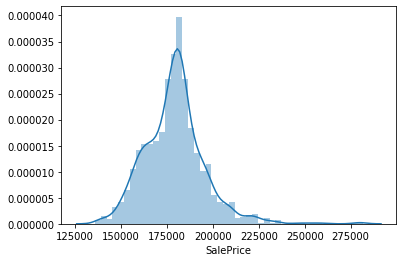

In [374]:
sns.distplot(target['SalePrice'])

In [9]:
print("Skewness: %f" % target.iloc[:,1].skew())
print("Kurtosis: %f" % target.iloc[:,1].kurt())

Skewness: 0.929360
Kurtosis: 3.794722


### Find out regression features

In [48]:
df_train.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [58]:
df_train.iloc[:,:20].head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000


In [59]:
df_train.iloc[:,20:40].head()

,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating
0,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA
1,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA
2,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA
3,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA
4,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA


In [72]:
df_train.iloc[:,40:60].head()

,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt
0,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0
1,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0
2,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0
3,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0
4,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0


In [178]:
df_train.iloc[:,60:80].head()

,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal


In [179]:
df_train.groupby("FullBath").mean()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
FullBath,,,,,,,,,,,,,,,,,,,,,
0,713.111111,64.444444,59.833333,14883.444444,5.000000,4.777778,1970.000000,1978.000000,38.555556,828.444444,...,204.111111,16.000000,0.000000,0.000000,0.000000,0.000000,66.666667,5.333333,2007.888889,165200.888889
1,726.238462,49.984615,65.480447,9187.786154,5.272308,5.876923,1954.215385,1974.564615,53.872111,405.801538,...,66.600000,28.426154,31.693846,2.049231,17.063077,1.883077,52.483077,6.167692,2007.818462,134751.440000
2,735.859375,62.506510,73.066773,11296.433594,6.740885,5.319010,1985.375000,1993.057292,138.326772,466.214844,...,112.553385,60.575521,13.601562,4.747396,12.674479,2.252604,34.869792,6.459635,2007.835938,213009.825521
3,694.454545,60.454545,91.344828,17360.484848,7.757576,5.818182,1979.181818,1999.000000,307.375000,558.606061,...,182.696970,90.333333,30.484848,0.000000,35.272727,32.545455,60.606061,6.424242,2007.272727,347822.909091


### Plot each feature scatter & distribution

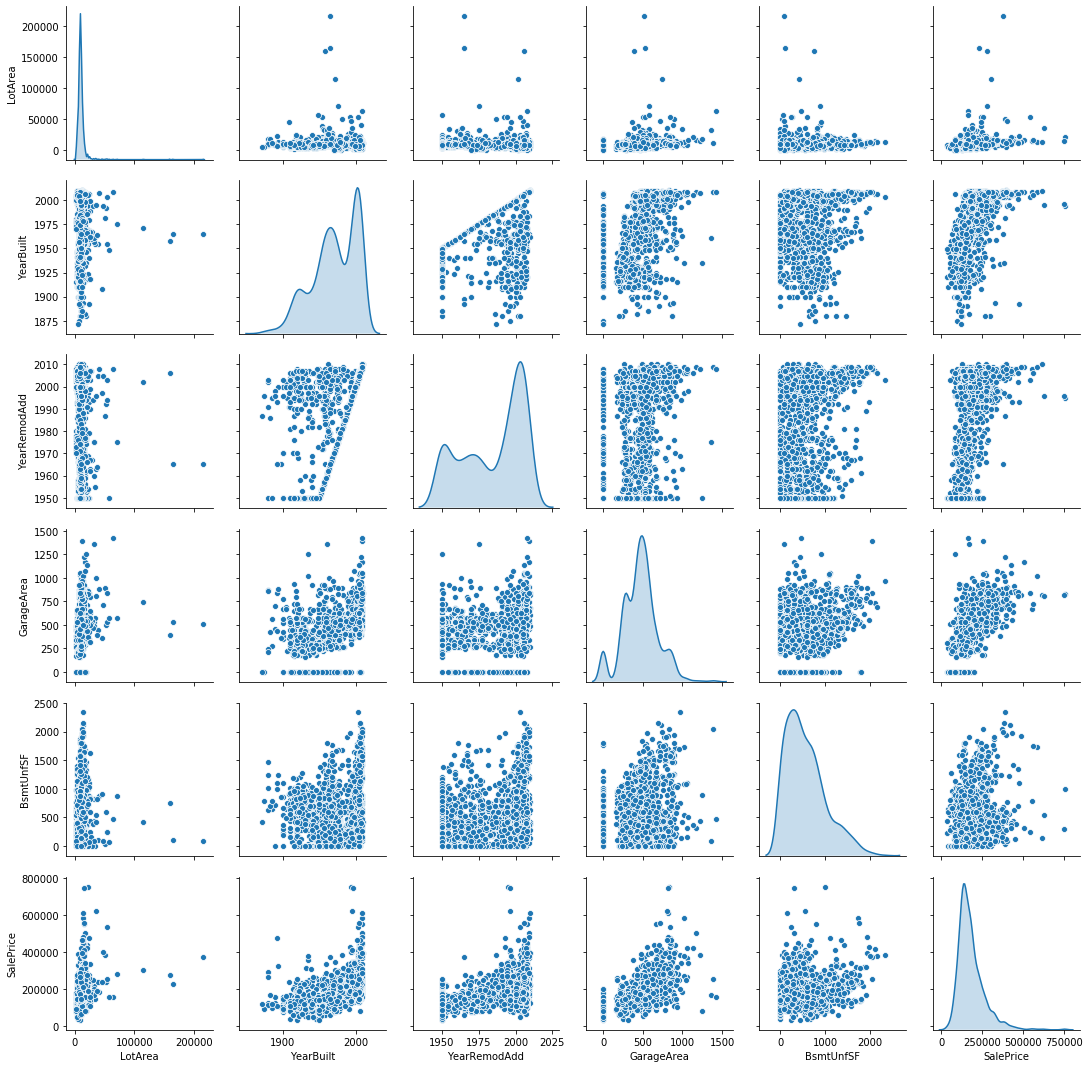

In [462]:
# 觀察 training set 的特徵分佈
sns.pairplot(data=df_train[['LotArea', 
                            'YearBuilt', 
                            'YearRemodAdd',
                            'GarageArea',
                            'BsmtUnfSF',
                            'SalePrice']],
             diag_kind = 'kde')

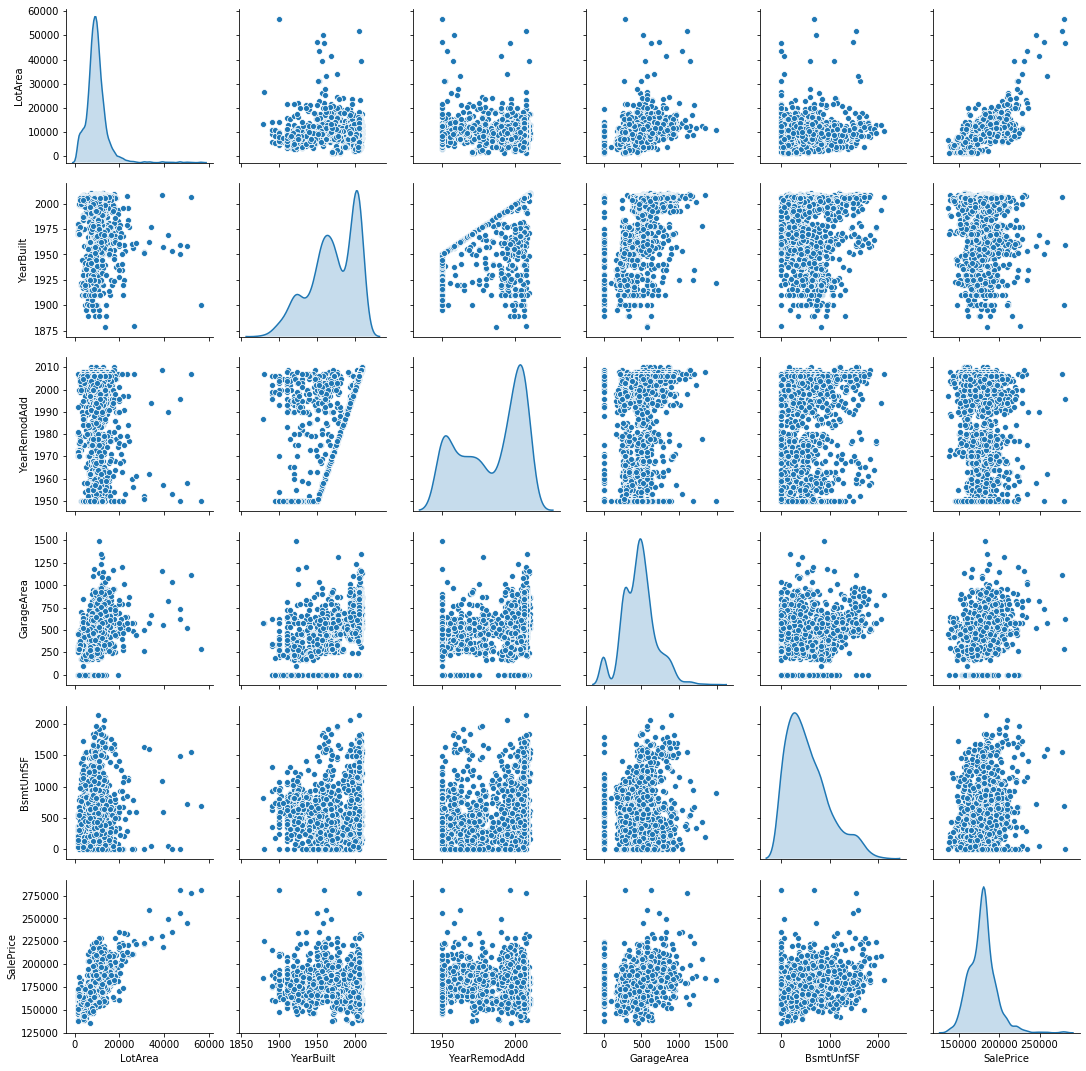

In [458]:
# 觀察 testing set 的特徵分佈
sns.pairplot(data=df_test[['LotArea',
                           'YearBuilt',
                           'YearRemodAdd',
                           'GarageArea',
                           'BsmtUnfSF', 
                           'SalePrice']],
             diag_kind = 'kde')

### Splitting training and validation set

In [463]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(df_train[['LotArea', 'YearBuilt','YearRemodAdd']].values, 
                                                  df_train['SalePrice'].values, 
                                                  test_size = 0.3, 
                                                  random_state = 91064,
                                                 shuffle = True)

In [464]:
print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)

(1022, 3)
(438, 3)
(1022,)
(438,)


### Linear Regression

In [465]:
from sklearn.linear_model import LinearRegression
regressor = LinearRegression().fit(X_train, y_train)
y_train_pred = regressor.predict(X_val)

In [466]:
from sklearn.metrics import mean_squared_error, r2_score
print('Training RMSE:',np.sqrt(mean_squared_error(y_val, y_train_pred)))
print('Training r2 score;',r2_score(y_val, y_pred))

Training RMSE: 62349.1001807002
Training r2 score; 0.39386604983739315


In [468]:
X_test = df_test[['LotArea', 'YearBuilt','YearRemodAdd']].values
y_test = target['SalePrice'].values


y_test_pred = regressor.predict(X_test)
print('Testing RMSE:',np.sqrt(mean_squared_error(y_test, y_test_pred)))
print('Testing r2 score;',r2_score(y_test, y_test_pred))

Testing RMSE: 49270.249179190156
Testing r2 score; -7.903001081175631


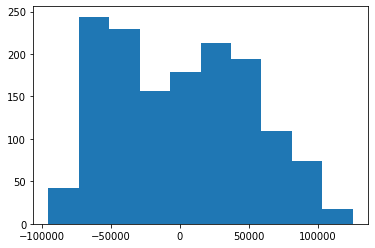

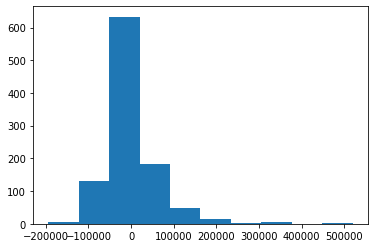

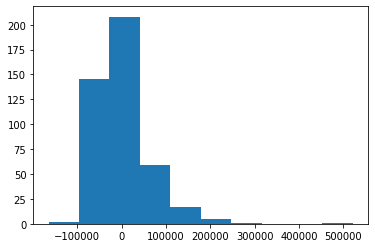

In [469]:
plt.hist(y_test-y_test_pred)
plt.show()
plt.hist(y_train-y_hat)
plt.show()
plt.hist(y_val-y_pred)
plt.show()

## KNN

In [ ]:
train = train.drop(["Id", "BsmtFinSF2"], axis=1)
test = test.drop(["Id", "BsmtFinSF2"], axis=1)


In [433]:
from sklearn.preprocessing import StandardScaler
std_scaler = StandardScaler()
X_train = std_scaler.fit_transform(X_train)  # 進行re-scaling
print(X_train)
X_val = std_scaler.transform(X_val) # 用同樣的scaler，對測試集進行re-scaling
print(X_val)

[[-0.41773068 -1.67374366  0.70187148]
 [-0.22871261 -0.51947107  0.50576386]
 [-0.1046695   0.17309248 -0.42574734]
 ...
 [-0.05696062  0.2060717  -0.37672044]
 [-0.52996016  0.99757291  0.79992529]
 [-0.13320396  0.2060717   0.21160243]]
[[-0.0555975   0.10713405 -0.52380115]
 [-0.33876112  1.12948977  1.04505982]
 [-0.07740728 -0.09074125 -0.81796259]
 ...
 [-0.26824284 -0.12372047  0.947006  ]
 [-0.1422005   0.403947   -0.08255901]
 [ 0.97991255  0.76671839  0.50576386]]
